# Deplatforming and Misinformation: Efficacy of Twitter's January 2021 User Suspensions

## Introduction

This analysis builds on the study, *Post-January 6th deplatforming reduced the reach of misinformation on Twitter* (McCabe et al. 2024), which examined Twitter's large-scale account suspensions following the January 6th, 2021 insurrection. Noting the significant role misinformation and conspiracy theories played, Twitter and other social media platforms implemented sweeping account suspensions to prevent their spread.

The goal of this project is to replicate and extend the findings of McCabe et al. using an anonymized replication dataset provided by the authors. I aim to further susbtantiate their conclusions to gauge the actual efficacy of Twitter's post-January 6th user suspensions. By doing so, I hope to improve the understanding of how social media platforms can mitigate the spread of misinformation and its impact on public discourse.

### Background and Context

The original research team compiled a pool of over 500,000 active Twitter users that could be cross-verified with a voter registration database, then assembled a dataset containing all of these users' activity between 2019 and 2021. 

Using multiple pre-curated lists of websites known to be sources of misinformation, the researchers focused specifically on tweets and retweets containing links to these websites.

Notes
- Aggregated Twitter data from late 2019 through 2021, focusing on URLs identified as misinformation
- Classified users into categories based on their activity levels and misinformation spread
- Used Difference-in-Differences (DiD) to measure the causal effect of deploatforming on misinformation spread

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import re, warnings, os
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib_venn as venn
import matplotlib.dates as mdates
from datetime import datetime, timedelta, date

warnings.filterwarnings(action="ignore")

## Data Preparation and Organization

In [17]:
# load data
mccabe = mccabe = pd.read_csv(
    "mccabe-public-data.csv", on_bad_lines="skip"
).reset_index(names=["ID"])
mccabe["group"] = mccabe["group"]
mccabe["date"] = pd.to_datetime(mccabe["date"], format="%Y-%m-%d")

### De-aggregating the data

To protect users' privacy, the replication data is available in an anonymized, aggregated format. The researchers divided the users into overlapping categories based on their activity levels and misinformation spread, then supplied the observed (mostly) daily counts for each group. 

Select Groups:
| Name | Group | Description |
|------|-------|-------------|
| FNS | misinformation sharers | users who share at least 1 URL with misinformation |
| DU | suspended users | users removed between January 6th and January 12th |
| HA | high activity | users who sent at least 3,200 tweets during a six-week collection interval between 2018 and April 2020 |
| MA | medium activity | the most active 500,000 users who didn't meet the high activity threshold |
| LA | low activity | all users who didn't meet the high or medium activity thresholds |
| A | Trump-only followers | non-suspended misinformation sharers who follow Trump but no other deplatformed users |
| B | deplatformed followers | non-suspended misinformation sharers who follow at least one deplatformed user (can include Trump) |
| D | 4+ deplatformed followers | non-suspended misinformation sharers who follow at least four deplatformed users (can include Trump) |
| F | not deplatformed followers | non-suspended misinformation sharers who do not follow any deplatformed users |

I used some probability rules to reorganize the data into a more usable (mutually exclusive) format.

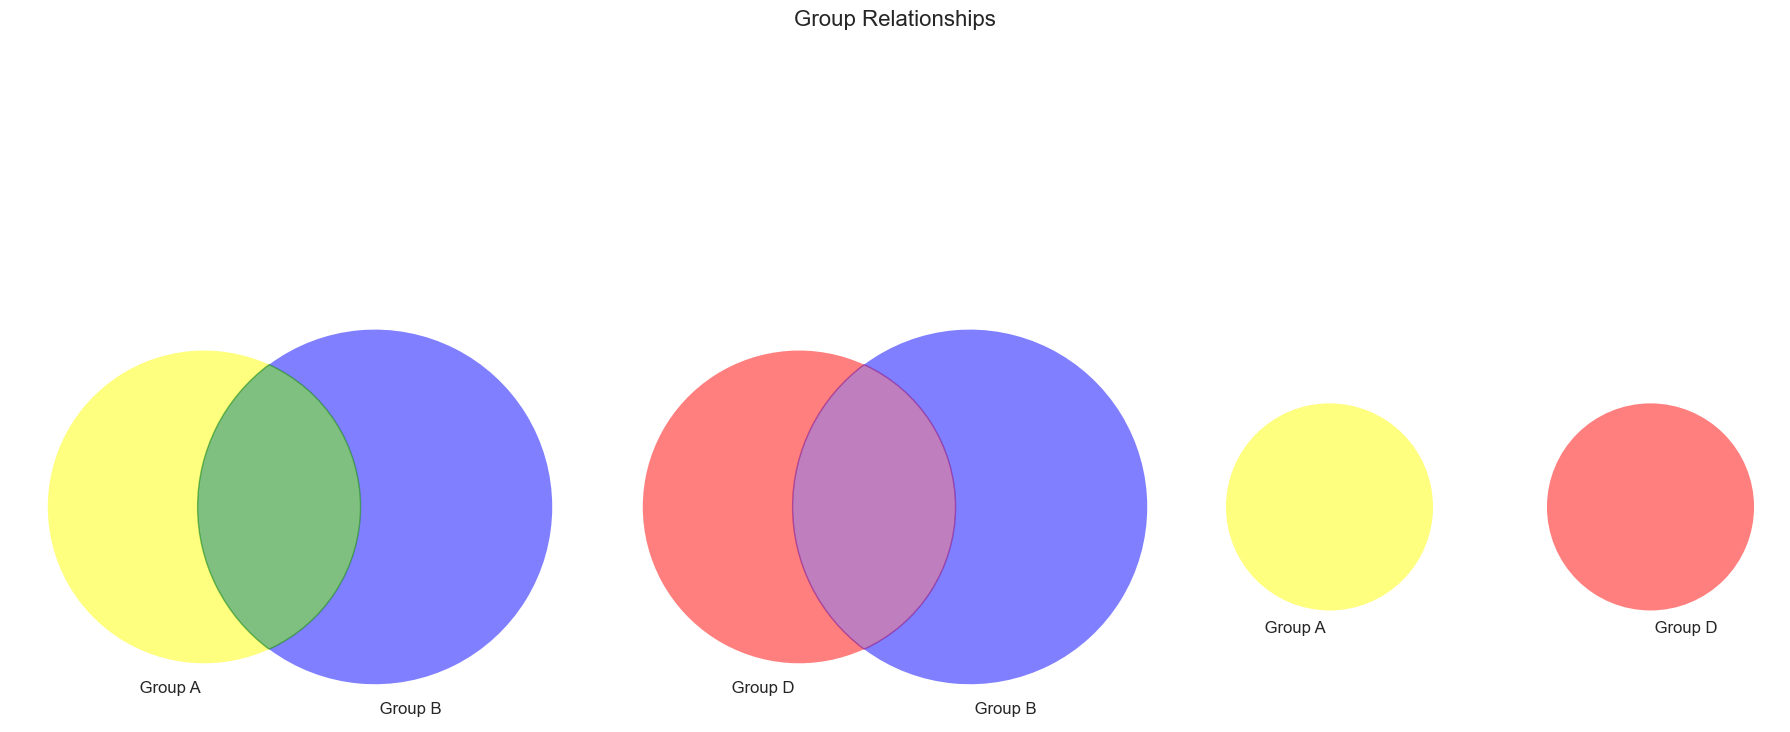

In [126]:
fig, ax = plt.subplots(1, 3, figsize=(18, 10))

v = venn.venn2(subsets=(4, 6, 3), set_labels=(' Group A ', ' Group B '), set_colors=('yellow', 'blue'), alpha=0.5, ax=ax[0])
v.get_label_by_id('10').set_text('')
v.get_label_by_id('01').set_text('')
v.get_label_by_id('11').set_text('')
v.get_patch_by_id('11').set_color('green')

w = venn.venn2(subsets=(4, 6, 3), set_labels=(' Group D ', ' Group B '), set_colors=('red', 'blue'), alpha=0.5, ax=ax[1])
w.get_label_by_id('10').set_text('')
w.get_label_by_id('01').set_text('')
w.get_label_by_id('11').set_text('')
w.get_patch_by_id('11').set_color('purple')

x = venn.venn2(subsets=(4, 4, 0), set_labels=(' Group A ', ' Group D '), set_colors=('yellow', 'red'), alpha=0.5, ax=ax[2])
x.get_label_by_id('10').set_text('')
x.get_label_by_id('01').set_text('')

fig.suptitle('Group Relationships', fontsize=16)
plt.tight_layout()
plt.show()

In [19]:
# one entry per group per day
numbers = [col for col in mccabe.columns if col not in ["ID", "date", "stat", "group"]]

mccabe_full = mccabe.groupby(["date", "group", "stat"])[numbers].sum().reset_index()

I built several functions to handle the disaggregation of the data. In addition to comparing and subtracting the subsets, I also added empty rows to the dataframes to make sure that the dataframes had the same number of rows. I will be aggregating the data later on, so this will not imapct the inteegrity of the data. It's also important to note that the disaggregation only breaks up the data into mutually exclusive categories, not into individual, user-level observations.

In [20]:
# add empty rows when subset has no activity (assume this is observed in the data)
def add_missing_level(df, set_name):
    if len(df["level"].unique()) < 3:
        missing = [l for l in ["ha", "ma", "la"] if l not in df["level"].unique()][0]

        empty = {}
        for col in df.columns:
            if col in ["grouping"]:
                empty[col] = set_name
            elif col in ["level"]:
                empty[col] = missing
            elif col == "stat":
                empty[col] = df["stat"].iloc[0]
            elif pd.api.types.is_numeric_dtype(df[col]):
                empty[col] = 0
            else:
                empty[col] = df[col].iloc[0]

        df = pd.concat([df, pd.DataFrame([empty])], ignore_index=True)

    return df


def preprocessing(df_raw, date):
    df = df_raw.loc[df_raw["date"] == date].reset_index(drop=True)

    ha, ma, la = [
        df.loc[(df["group"] == g) & (df["stat"] == "total")]
        for g in ["ha", "ma", "la"]
    ]

    su = df.loc[df["group"].str.contains(r"\_[hml]a")]

    groupings = (
        su["group"]
        .str.split("_", expand=True)
        .rename(columns={0: "grouping", 1: "level"})
    )

    sub = pd.concat(
        [su.drop(columns=["group"], errors="ignore"), groupings],
        axis=1,
    )

    groups = ["A", "D", "F", "nfns"]
    processed_groups = {}

    for g in groups:
        g_df = sub[sub["grouping"] == g].copy()
        out = []
        for stat in ["total", "avg"]:
            tmp = g_df[g_df["stat"] == stat]
            tmp = add_missing_level(tmp, g)
            tmp["date"] = date
            out.append(tmp)
        processed_groups[g] = out

    return ha, ma, la, processed_groups, sub, groups


def process_suspended(suspended):

    suspended_common = pd.DataFrame(
        {
            "stat": "total",
            "grouping": "suspended",
            "level": ["ha", "ma", "la"],
        }
    )
    suspended = suspended.reset_index().join(suspended_common, rsuffix="_common")
    return suspended


def pull_B(sub, processed_groups):
    numeric_cols = sub.select_dtypes(include="number").columns

    B_total = add_missing_level(
        sub[(sub["grouping"] == "B") & (sub["stat"] == "total")], "B"
    )
    B_avg = add_missing_level(
        sub[(sub["grouping"] == "B") & (sub["stat"] == "avg")], "B"
    )

    A_tot = processed_groups["A"][0].set_index("level")[numeric_cols]
    D_tot = processed_groups["D"][0].set_index("level")[numeric_cols]

    A_avg = processed_groups["A"][1].set_index("level")[numeric_cols]
    D_avg = processed_groups["D"][1].set_index("level")[numeric_cols]

    B_tot_vals = B_total.set_index("level")[numeric_cols]
    resid_tot = B_tot_vals - A_tot - D_tot

    resid_avg = (
        B_avg.set_index("level")[numeric_cols] * B_tot_vals
        - A_avg * A_tot
        - D_avg * D_tot
    ) / resid_tot.replace(0, np.nan)

    def finalize(df, stat):
        out = df.reset_index()
        out["grouping"] = "B"
        out["stat"] = stat
        return out

    B_total_out = finalize(resid_tot, "total")
    B_avg_out = finalize(resid_avg, "avg")

    return numeric_cols, pd.concat([B_total_out, B_avg_out], ignore_index=True)


def impute_NDU(B, ha, ma, la, processed_groups, groups):
    all_levels = (
        pd.concat([ha, ma, la])
        .rename(columns={"group": "level"})
        .set_index("level")
    )

    ndu = {}
    for stat in ["total", "avg"]:
        parts = []
        for g in groups:
            parts.append(processed_groups[g][0 if stat == "total" else 1])
        parts.append(B[B["stat"] == stat])

        tmp = (
            pd.concat(parts)
            .groupby("level")
            .sum(numeric_only=True)
        )
        tmp["stat"] = stat
        ndu[stat] = tmp

    return all_levels, ndu


def recombine(date, processed_groups, B, suspended):
    dfs_to_concat = []
    for group in processed_groups.values():
        for item in group:
            if isinstance(item, pd.DataFrame):
                dfs_to_concat.append(item)

    if not isinstance(B, pd.DataFrame):
        B = pd.DataFrame(B)

    if date < datetime(2021, 1, 12):
        suspended_p = process_suspended(suspended)
        dfs_to_concat.append(suspended_p)

    exclusive_groups = pd.concat(dfs_to_concat, ignore_index=True)

    return exclusive_groups


def aggregation_func(df_raw, date):
    ha, ma, la, processed_groups, sub, groups = preprocessing(df_raw, date)

    numeric_columns, B = pull_B(sub, processed_groups)

    all_levels, ndu = impute_NDU(B, ha, ma, la, processed_groups, groups)

    suspended_total = all_levels[numeric_columns] - ndu["total"][numeric_columns]

    suspended_avg = (
        all_levels[numeric_columns] * all_levels[numeric_columns]
        - ndu["avg"][numeric_columns] * ndu["total"][numeric_columns]
    ) / suspended_total.replace(0, np.nan)

    suspended = pd.concat([
        suspended_total.assign(stat="total"),
        suspended_avg.assign(stat="avg")
    ])
    suspended["grouping"] = "suspended"
    suspended["date"] = date

    final = recombine(date, processed_groups, B, suspended)
    return final

In [30]:
mut_exclusive_groups = []

for day in mccabe_full["date"].unique():
    mut_exclusive_groups.append(aggregation_func(mccabe_full, day))

total = pd.concat(mut_exclusive_groups).reset_index(drop=True)
# Create a new column 'subsets' by combining 'grouping' and 'level'
total.loc[:, "subsets"] = total["grouping"] + "_" + total["level"]
total = total.drop(columns=["grouping_common", "stat_common", "level_common"]).reset_index(
    drop=True
)


In [33]:
# total.to_csv("total.csv", index=False)
total = pd.read_csv("total.csv")

In [34]:
total['date'] = pd.to_datetime(total['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").date()))
total['subset_group'] = total['subsets'].apply(lambda x: x.split('_')[0])
total['subset_activity'] = total['subsets'].apply(lambda x: x.split('_')[1])

Data collection was an inexhaustive process, so it's important to verify the sudden changes in each groups' behavior. Some changes can be explained by parallel changes in other groups; the number of low activity users sharply declines around July 2020, but at the same time the number of high activity users sharply increases. 

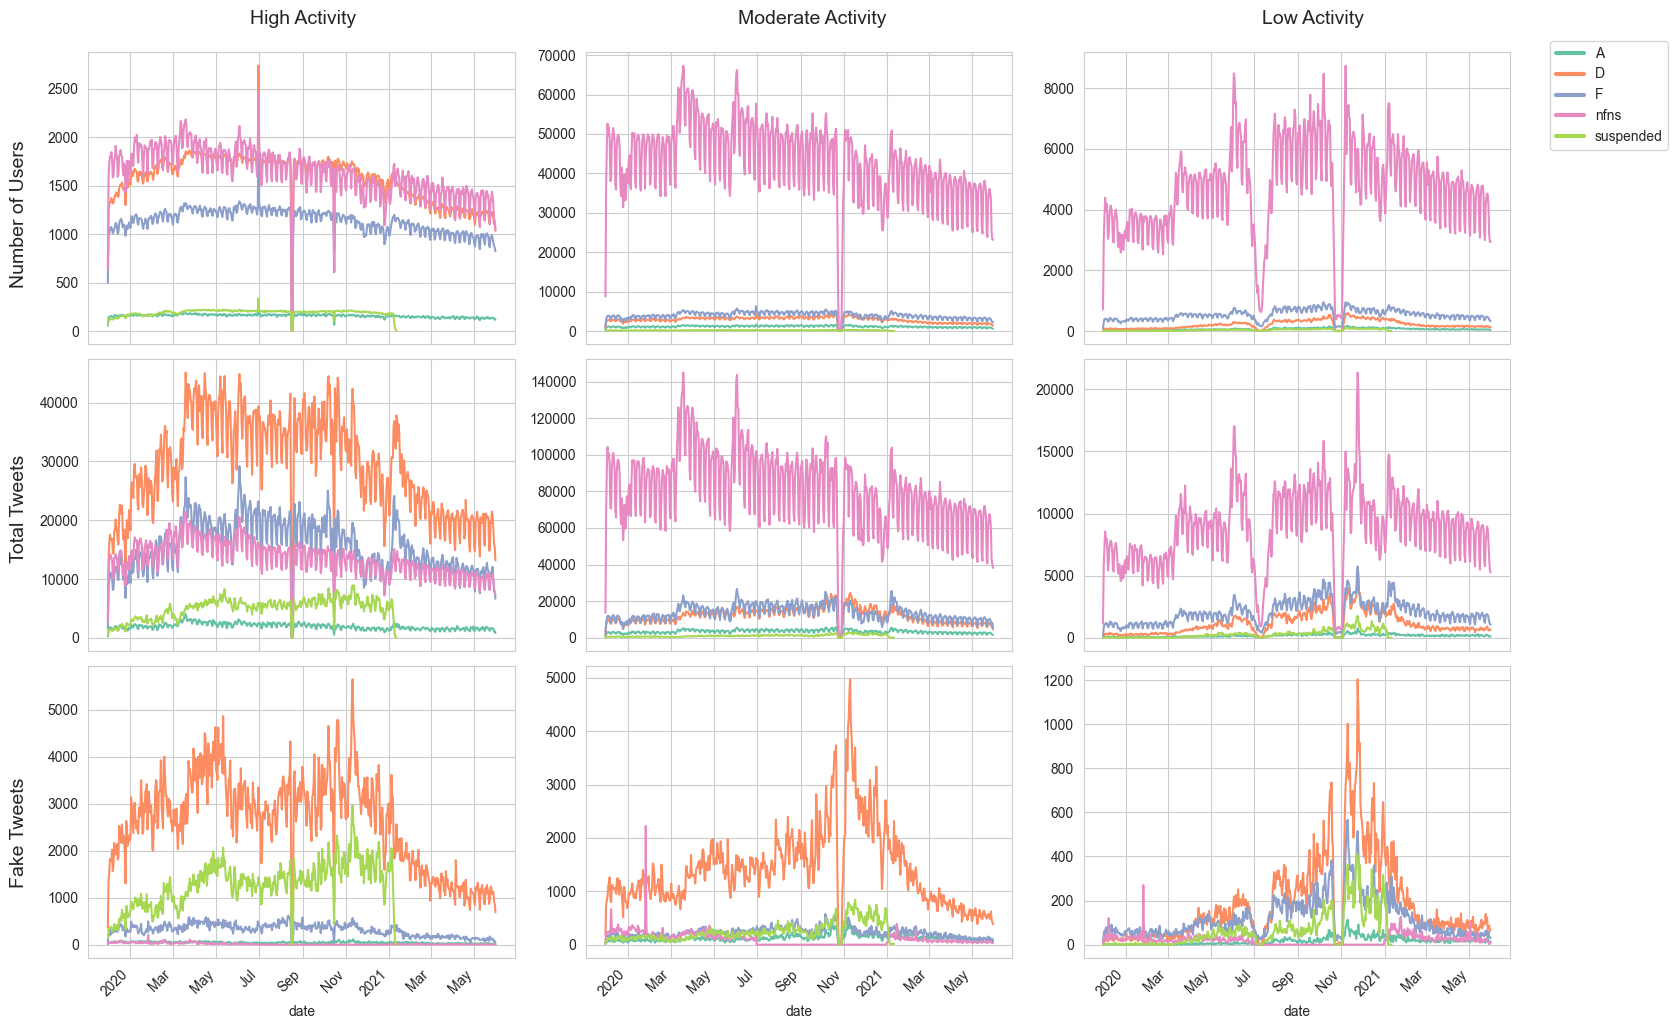

In [133]:
fig, ax = plt.subplots(3, 3, figsize=(15, 10), sharex=True)
for L in total['subset_activity'].unique():
    if L == 'ha':
        i = 0
        title = 'High'
    elif L == 'ma':
        i = 1
        title = 'Moderate'
    else:
        i = 2
        title = 'Low'
    d = total.loc[total['subset_activity'] == L]
    sns.lineplot(d, x='date', y='nusers', hue='subset_group', palette='Set2', ax=ax[0, i])
    sns.lineplot(d, x='date', y='n', hue='subset_group', palette='Set2', ax=ax[1, i])
    sns.lineplot(d, x='date', y='fake_merged', hue='subset_group', palette='Set2', ax=ax[2, i])

fig.text(-0.01, 0.75, 'Number of Users', rotation=90, fontsize=14)
fig.text(-0.01, 0.475, 'Total Tweets', rotation=90, fontsize=14)
fig.text(-0.01, 0.15, 'Fake Tweets', rotation=90, fontsize=14)

fig.text(0.15, 1.01, 'High Activity', fontsize=14)
fig.text(0.475, 1.01, 'Moderate Activity', fontsize=14)
fig.text(0.825, 1.01, 'Low Activity', fontsize=14)

handles, labels = ax[0, 0].get_legend_handles_labels()
for h in handles:
    h.set_linewidth(3)
fig.legend(handles, labels, loc='upper right', ncol=1, bbox_to_anchor=(1.1, 1))

for a in ax.flatten():
    a.xaxis.set_major_locator(mdates.AutoDateLocator())
    a.xaxis.set_major_formatter(mdates.ConciseDateFormatter(a.xaxis.get_major_locator()))
    plt.setp(a.xaxis.get_majorticklabels(), rotation=45, ha='right')
    a.get_legend().remove()
    a.yaxis.set_label_text('')

plt.tight_layout()
plt.show()

In [134]:
features = ['fake_merged_initiation', 'fake_merged_rt', 'not_fake_conservative', 'not_fake_liberal', 'not_fake_shopping', 'not_fake_sports', 'n', 'nusers', 'subset_group', 'subset_activity', 'date']

df = total.copy().loc[:, features].pivot_table(index='date', columns=['subset_group', 'subset_activity'], values=['fake_merged_initiation', 'fake_merged_rt', 'not_fake_conservative', 'not_fake_liberal', 'not_fake_shopping', 'not_fake_sports', 'n', 'nusers'], fill_value=0).asfreq('D').fillna(0)
df.columns = ['_'.join(col).strip() for col in df.columns.values]

treatment_start = '2021-01-12'
treatment_end = '2021-01-19'

pretreatment_df = df.loc[:treatment_start]
posttreatment_df = df.loc[treatment_end:]

In [135]:
from adtk.detector import MinClusterDetector
from adtk.pipe import Pipeline
from adtk.data import validate_series
from adtk.transformer import PcaProjection
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

min_cluster_detector = MinClusterDetector(KMeans(n_clusters=4))
steps = [
    ("projection", PcaProjection(k=2)),
    ("detector", min_cluster_detector)
]
pipeline = Pipeline(steps)
pre_treated = validate_series(pretreatment_df)
pre_anomalies = pipeline.fit_detect(pre_treated).reset_index().rename(columns={0: "anomaly"})

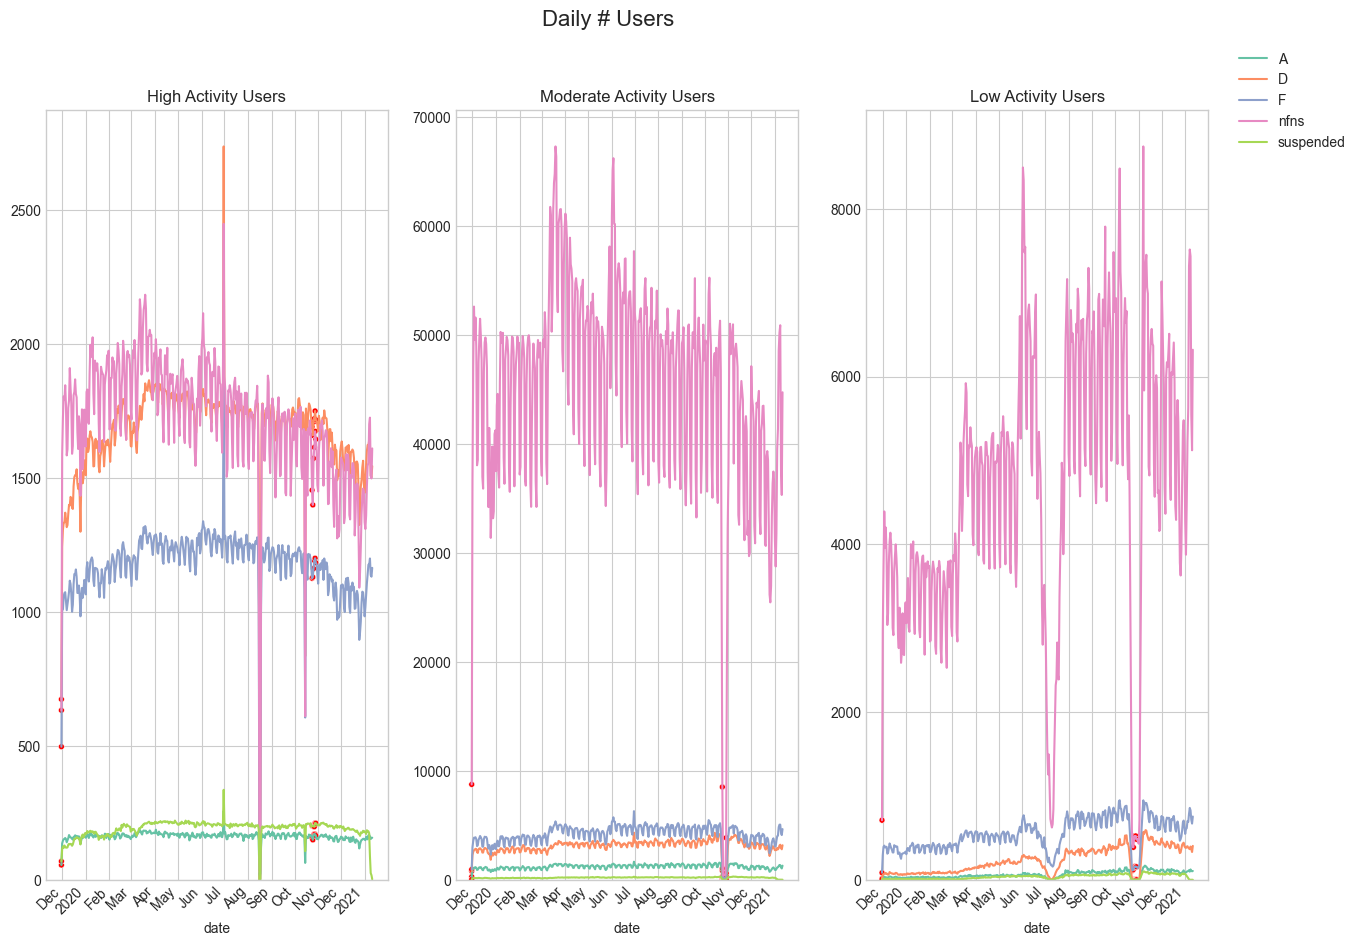

In [136]:
pre_outlier_data = total.loc[total['date'] < '2021-01-12'].join(pre_anomalies.set_index('date'), on='date')
plt.style.use('seaborn-v0_8-whitegrid')

fig, ax = plt.subplots(1, 3, figsize=(15, 10))

for L in ['ha', 'ma', 'la']:
    if L == 'ha':
        i = 0
        title = 'High'
    elif L == 'ma':
        i = 1
        title = 'Moderate'
    else:
        i = 2
        title = 'Low'
    name = f"{title} Activity Users"
    sns.lineplot(x='date', y='nusers', data=pre_outlier_data.loc[pre_outlier_data['subset_activity'] == L], ax=ax[i], hue='subset_group', palette='Set2')
    sns.scatterplot(x='date', y='nusers', data=pre_outlier_data.loc[(pre_outlier_data['subset_activity'] == L) & (pre_outlier_data['anomaly'] == True)], ax=ax[i], color='red', legend=False, size=800)
    ax[i].set_title(name)
fig.suptitle('Daily # Users', fontsize=16)

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=1, bbox_to_anchor=(1.0, 0.95))
for a in ax:
    a.xaxis.set_major_locator(mdates.MonthLocator())
    a.xaxis.set_major_formatter(mdates.ConciseDateFormatter(a.xaxis.get_major_locator()))
    plt.setp(a.xaxis.get_majorticklabels(), rotation=45, ha='right')
    a.get_legend().remove()
    a.set_ylim(0)
    a.yaxis.set_label_text('')

The main outliers seem to be the earliest observations, as well as the general downward trend in November 2020.

## Modeling

### Estimands

To isolate behavioral change from mechanical reductions in platform activity, all primary outcomes are defined as *rates* rather than raw volumes.

For each non-suspended user subset $s$ on day $t$:

**Fake share of activity (per tweet):**

$$[
y^{tweet}_{st} =
\frac{\text{fake merged initiation}_{st} + \text{fake merged rt}_{st}}
{\text{total tweets}_{st}}
]$$

**Fake per active user:**

$$[
y^{user}_{st} =
\frac{\text{fake merged initiation}_{st} + \text{fake merged rt}_{st}}
{\text{active users}_{st}}
]$$

The primary estimand is the causal effect of the January 6–12 suspension ramp on the misinformation rate among *non-suspended* users.

The main outcome is the pooled fake share per tweet across all non-suspended users. The per-user outcome is treated as secondary.

### Treatment Definition

Suspensions occurred gradually between January 6 and January 12, 2021. Rather than modeling treatment as a binary indicator, I construct a continuous exposure variable:

$$[
\text{S dose}_t = 1 - \frac{\text{suspended users}_t}{\text{pre-suspension baseline}}
]$$

This captures the fraction of suspended users removed relative to baseline levels immediately before January 6.

This “dose” specification reflects the gradual nature of deplatforming and allows identification of marginal changes in misinformation rates as suspension intensity increases.

I additionally include:

* A short pulse control for January 6–7.
* Day-of-week fixed effects.
* Controls for non-fake political and non-political content shares.

### Event-Study Specification

To assess dynamics and pre-trends, I estimate:

$$[
y_t = \sum_{k \neq -1} \beta_k \mathbb{1}\{t - T = k\} * \gamma \text{S dose}_t * \delta \text{Pulse}_t * \theta X_t * \varepsilon_t
]$$

where:

* $T$ = January 12, 2021
* Event time window: -90 to +90 days
* Event bins truncated at [-30, 60]
* HAC standard errors (7 lags)
* Block bootstrap (7-day blocks, 300 reps)

The omitted period is $k = -1$.

Parallel pre-trends are tested via joint F-tests on all $k < 0$.

### Inference

Two inference procedures are used:

* **HAC (Newey–West)** standard errors to account for autocorrelation.
* **Block bootstrap** to construct confidence bands for event-study coefficients.

Results are substantively identical across both approaches; bootstrap intervals are reported in figures.

In [124]:
DATA_PATH = "total.csv"

TREAT_START = pd.Timestamp("2021-01-06")
TREAT_END = pd.Timestamp("2021-01-12")
TREAT_REF = pd.Timestamp("2021-01-12")

WIN_PRE = 90
WIN_POST = 90

LEFT_BIN = -30
RIGHT_BIN = 60
OMIT_K = -1

MAXLAGS_HAC = 7
BLOCK_LEN = 7
BOOT_REPS = 800
SEED = 7
ALPHA = 0.05

SUBSETS_NON_SUSP = [
    "A_ha","A_ma","A_la",
    "D_ha","D_ma","D_la",
    "F_ha","F_ma","F_la",
    "nfns_ha","nfns_ma","nfns_la"
]

SUBSETS_SUSP = ["suspended_ha","suspended_ma","suspended_la"]

CONTROL_SETS = {
    "all": ["cons","lib","shop","sports"],
    "political_only": ["cons","lib"],
    "nonpolitical_only": ["shop","sports"],
    "none": []
}

CONTROL_GROUPS = ["cons","lib","shop","sports"]

def safe_div(a, b, eps=1e-12):
    return a / (b + eps)

def winsorize(s, p=0.01):
    lo = s.quantile(p)
    hi = s.quantile(1 - p)
    return s.clip(lo, hi)

def block_bootstrap_indices(n, block_len, rng):
    starts = np.arange(0, n, block_len)
    chosen = rng.choice(starts, size=len(starts), replace=True)
    idx = []
    for s in chosen:
        idx.extend(range(s, min(s + block_len, n)))
    return np.array(idx[:n], dtype=int)

def add_constant(X):
    return sm.add_constant(X, has_constant="add")

def as_numeric(df, cols):
    for c in cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def ensure_all_columns(wide, subsets, value_cols):
    for s in subsets:
        for v in value_cols:
            col = f"{v}_{s}"
            if col not in wide.columns:
                wide[col] = 0.0
    return wide

def make_event_time(df, ref_date):
    return (df.index - ref_date).days.astype(int)

def make_ramp(df_index, start, end):
    ramp_num = (df_index - start).days.astype(float)
    ramp_den = float((end - start).days)
    return np.clip(ramp_num / ramp_den, 0.0, 1.0)

def format_p(p):
    if p is None or not np.isfinite(p):
        return ""
    if p < 1e-3:
        return "<0.001"
    return f"{p:.3f}"

def star(p):
    if p is None or not np.isfinite(p):
        return ""
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    return ""

def fmt_coef_se(coef, se, p):
    if coef is None or se is None or not np.isfinite(coef) or not np.isfinite(se):
        return ""
    return f"{coef:.4f}{star(p)} ({se:.4f})"

def extract_term(model, cols, term):
    if model is None or cols is None or term not in cols:
        return None, None, None
    j = cols.index(term)
    return float(model.params[j]), float(model.bse[j]), float(model.pvalues[j])

In [125]:
# data preparation
def load_and_pivot_total(path):
    df = pd.read_csv(path)
    df["date"] = pd.to_datetime(df["date"])
    df["stat"] = df["stat"].astype(str).str.lower()
    df["subsets"] = df["subsets"].astype(str)

    df = df[df["stat"] == "total"].copy()
    df = df.dropna(subset=["date", "subsets"]).copy()

    value_cols = [
        "fake_merged_initiation","fake_merged_rt",
        "not_fake_conservative_initiation","not_fake_conservative_rt",
        "not_fake_liberal_initiation","not_fake_liberal_rt",
        "not_fake_shopping_initiation","not_fake_shopping_rt",
        "not_fake_sports_initiation","not_fake_sports_rt",
        "n","nusers"
    ]
    df = as_numeric(df, value_cols)
    df = df.sort_values(["date","subsets"])

    wide = df.pivot_table(index="date", columns="subsets", values=value_cols, aggfunc="sum")
    wide.columns = [f"{v}_{s}" for v, s in wide.columns]
    wide = wide.sort_index()
    wide = wide.apply(pd.to_numeric, errors="coerce").fillna(0.0)

    wide = ensure_all_columns(wide, SUBSETS_NON_SUSP + SUBSETS_SUSP, value_cols)
    wide = wide.sort_index()

    return wide, value_cols

In [126]:
# window construction
def build_window_frame(wide, ref_date, start_treat, win_pre, win_post):
    start_window = ref_date - pd.Timedelta(days=win_pre)
    end_window   = ref_date + pd.Timedelta(days=win_post)

    w = wide.loc[(wide.index >= start_window) & (wide.index <= end_window)].copy()

    w["dow"] = w.index.dayofweek.astype(int)
    w["k"] = (w.index - ref_date).days.astype(int)
    w["k_bin"] = w["k"].clip(LEFT_BIN, RIGHT_BIN).astype(int)

    w["ramp"] = make_ramp(w.index, start_treat, ref_date)

    w["pulse_jan6_7"] = ((w.index >= pd.Timestamp("2021-01-06")) &
                         (w.index <= pd.Timestamp("2021-01-07"))).astype(int)

    w["susp_nusers"] = (
        w["nusers_suspended_ha"] +
        w["nusers_suspended_ma"] +
        w["nusers_suspended_la"]
    )

    pre_series = wide.loc[
        wide.index < start_treat,
        ["nusers_suspended_ha","nusers_suspended_ma","nusers_suspended_la"]
    ].sum(axis=1)

    pre_baseline = pre_series.tail(14).mean()
    if not np.isfinite(pre_baseline) or pre_baseline <= 0:
        pre_baseline = max(pre_series.mean(), 1.0)

    w["S_dose"] = 1.0 - (w["susp_nusers"] / pre_baseline)
    w["S_dose"] = w["S_dose"].clip(0.0, 1.0)

    return w

In [143]:
# outcomes and controls
def construct_outcomes_and_controls(w):
    for subset in SUBSETS_NON_SUSP:
        fi = f"fake_merged_initiation_{subset}"
        fr = f"fake_merged_rt_{subset}"

        cci = f"not_fake_conservative_initiation_{subset}"
        ccr = f"not_fake_conservative_rt_{subset}"
        lli = f"not_fake_liberal_initiation_{subset}"
        llr = f"not_fake_liberal_rt_{subset}"
        shi = f"not_fake_shopping_initiation_{subset}"
        shr = f"not_fake_shopping_rt_{subset}"
        spi = f"not_fake_sports_initiation_{subset}"
        spr = f"not_fake_sports_rt_{subset}"

        ncol = f"n_{subset}"
        ucol = f"nusers_{subset}"

        w[f"fake_total_{subset}"] = w[fi] + w[fr]
        w[f"nf_cons_total_{subset}"] = w[cci] + w[ccr]
        w[f"nf_lib_total_{subset}"] = w[lli] + w[llr]
        w[f"nf_shop_total_{subset}"] = w[shi] + w[shr]
        w[f"nf_sports_total_{subset}"] = w[spi] + w[spr]

        w[f"y_fake_share_tweet_{subset}"] = safe_div(w[f"fake_total_{subset}"], w[ncol])
        w[f"y_fake_per_user_{subset}"] = safe_div(w[f"fake_total_{subset}"], w[ucol])

        w[f"c_cons_tweet_{subset}"] = safe_div(w[f"nf_cons_total_{subset}"], w[ncol])
        w[f"c_lib_tweet_{subset}"]  = safe_div(w[f"nf_lib_total_{subset}"],  w[ncol])
        w[f"c_shop_tweet_{subset}"] = safe_div(w[f"nf_shop_total_{subset}"], w[ncol])
        w[f"c_sports_tweet_{subset}"] = safe_div(w[f"nf_sports_total_{subset}"], w[ncol])

        w[f"c_cons_user_{subset}"] = safe_div(w[f"nf_cons_total_{subset}"], w[ucol])
        w[f"c_lib_user_{subset}"]  = safe_div(w[f"nf_lib_total_{subset}"],  w[ucol])
        w[f"c_shop_user_{subset}"] = safe_div(w[f"nf_shop_total_{subset}"], w[ucol])
        w[f"c_sports_user_{subset}"] = safe_div(w[f"nf_sports_total_{subset}"], w[ucol])

    return w

def pooled_outcome(w, kind="tweet", subsets=None):
    if subsets is None:
        subsets = SUBSETS_NON_SUSP

    parts = []
    weights = []
    for subset in subsets:
        if kind == "tweet":
            y = w[f"y_fake_share_tweet_{subset}"]
            wt = w[f"n_{subset}"]
        else:
            y = w[f"y_fake_per_user_{subset}"]
            wt = w[f"nusers_{subset}"]
        parts.append(y * wt)
        weights.append(wt)
    return safe_div(sum(parts), sum(weights))

def pooled_controls(w, kind="tweet", subsets=None):
    if subsets is None:
        subsets = SUBSETS_NON_SUSP

    ctrl = {}
    for g in CONTROL_GROUPS:
        parts = []
        weights = []
        for subset in subsets:
            if kind == "tweet":
                c = w[f"c_{g}_tweet_{subset}"]
                wt = w[f"n_{subset}"]
            else:
                c = w[f"c_{g}_user_{subset}"]
                wt = w[f"nusers_{subset}"]
            parts.append(c * wt)
            weights.append(wt)
        ctrl[g] = safe_div(sum(parts), sum(weights))
    return pd.DataFrame(ctrl, index=w.index)

In [144]:
# design matrix
def make_k_dummies(w):
    k_d = pd.get_dummies(w["k_bin"].astype(int), prefix="k")
    omit = f"k_{OMIT_K}"
    if omit in k_d.columns:
        k_d = k_d.drop(columns=[omit])
    k_cols = list(k_d.columns)
    return k_d, k_cols

def make_dow_dummies(w):
    return pd.get_dummies(w["dow"].astype(int), prefix="dow", drop_first=True)

def build_X(w, y_kind="tweet", include_controls=True, include_k=True,
            control_set_name="all", subsets=None):

    if subsets is None:
        subsets = SUBSETS_NON_SUSP

    parts = []
    k_cols = []

    if include_k:
        k_d, k_cols = make_k_dummies(w)
        parts.append(k_d)

    parts.append(w[["S_dose","pulse_jan6_7"]].copy())

    if include_controls and control_set_name != "none":
        C = pooled_controls(w, kind=y_kind, subsets=subsets)
        use = CONTROL_SETS.get(control_set_name, CONTROL_SETS["all"])
        parts.append(C[use])

    parts.append(make_dow_dummies(w))

    X = pd.concat(parts, axis=1)
    X = X.apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)
    X = X.loc[:, X.nunique(dropna=True) > 1]

    return X, k_cols

In [145]:
# modeling
def fit_ols_hac(y, X, maxlags=MAXLAGS_HAC):
    y = pd.to_numeric(y, errors="coerce").replace([np.inf, -np.inf], np.nan)
    tmp = pd.concat([y.rename("y"), X], axis=1).dropna()

    yv = tmp["y"].astype(float).values
    Xdf = tmp.drop(columns=["y"]).astype(float)
    Xv = add_constant(Xdf.values)

    if Xv.shape[0] <= Xv.shape[1]:
        return None, None

    m = sm.OLS(yv, Xv).fit(cov_type="HAC", cov_kwds={"maxlags": maxlags})
    cols = ["const"] + list(Xdf.columns)
    return m, cols

def coef_summary(model, cols, terms):
    rows = []
    if model is None or cols is None:
        for t in terms:
            rows.append({"term": t, "coef": np.nan, "se": np.nan, "p": np.nan})
        return pd.DataFrame(rows)

    for t in terms:
        if t in cols:
            j = cols.index(t)
            rows.append({"term": t,
                         "coef": float(model.params[j]),
                         "se": float(model.bse[j]),
                         "p": float(model.pvalues[j])})
        else:
            rows.append({"term": t, "coef": np.nan, "se": np.nan, "p": np.nan})
    return pd.DataFrame(rows)

def joint_pretrend_test(model, cols, k_cols):
    if model is None or cols is None:
        return None
    pre = [c for c in k_cols if c in cols and int(c.split("_")[1]) < 0]
    pre = [c for c in pre if c != f"k_{OMIT_K}"]
    if len(pre) == 0:
        return None

    idx = [cols.index(c) for c in pre]
    R = np.zeros((len(idx), len(cols)))
    for i, j in enumerate(idx):
        R[i, j] = 1.0
    r = np.zeros(len(idx))

    ft = model.f_test((R, r))
    return float(ft.pvalue)

def block_bootstrap_params(y, X, reps=BOOT_REPS, block_len=BLOCK_LEN, seed=SEED):
    rng = np.random.default_rng(seed)

    y = pd.to_numeric(y, errors="coerce").replace([np.inf, -np.inf], np.nan)
    tmp = pd.concat([y.rename("y"), X], axis=1).dropna()

    yv = tmp["y"].astype(float).values
    Xdf = tmp.drop(columns=["y"]).astype(float)
    Xv = add_constant(Xdf.values)

    cols = ["const"] + list(Xdf.columns)

    n = len(yv)
    if n < 30 or Xv.shape[0] <= Xv.shape[1]:
        return None, cols

    params = []
    for _ in range(reps):
        bidx = block_bootstrap_indices(n, block_len, rng)
        try:
            mb = sm.OLS(yv[bidx], Xv[bidx, :]).fit()
            params.append(mb.params)
        except Exception:
            continue

    if len(params) < max(100, reps // 4):
        return None, cols

    return np.asarray(params), cols

def event_study_ci_from_boot(P, cols, k_cols, alpha=ALPHA):
    if P is None or cols is None:
        return None

    col_to_idx = {c:i for i,c in enumerate(cols)}
    ks = []
    idxs = []
    for c in k_cols:
        if c in col_to_idx:
            ks.append(int(c.split("_")[1]))
            idxs.append(col_to_idx[c])

    if len(ks) == 0:
        return None

    ks = np.array(ks, dtype=int)
    B = P[:, idxs]

    lo  = np.quantile(B, alpha/2, axis=0)
    hi  = np.quantile(B, 1 - alpha/2, axis=0)
    mid = np.quantile(B, 0.5, axis=0)

    order = np.argsort(ks)

    return pd.DataFrame({
        "k": ks[order],
        "mid": mid[order],
        "lo": lo[order],
        "hi": hi[order],
    })

In [146]:
# plotting
def plot_event_study(es_df, title, vline_at=0):
    plt.figure(figsize=(10, 4))
    plt.axhline(0, linewidth=1)
    plt.axvline(vline_at, linestyle="--", linewidth=1)
    plt.fill_between(es_df["k"], es_df["lo"], es_df["hi"], alpha=0.2)
    plt.plot(es_df["k"], es_df["mid"], marker="o", linewidth=1)
    plt.title(title)
    plt.xlabel("Days relative to Jan 12, 2021")
    plt.ylabel("Event-study coefficient")
    plt.tight_layout()
    plt.show()

def plot_three_panel_event_study(es_map, suptitle):
    fig = plt.figure(figsize=(10, 9))
    keys = list(es_map.keys())
    for i, k in enumerate(keys, start=1):
        ax = fig.add_subplot(3, 1, i)
        df = es_map[k]
        ax.axhline(0, linewidth=1)
        ax.axvline(0, linestyle="--", linewidth=1)
        ax.fill_between(df["k"], df["lo"], df["hi"], alpha=0.2)
        ax.plot(df["k"], df["mid"], marker="o", linewidth=1)
        ax.set_title(k)
        ax.set_xlabel("Days relative to Jan 12, 2021")
        ax.set_ylabel("Coef")
    fig.suptitle(suptitle, y=0.98)
    plt.tight_layout()
    plt.show()

In [147]:
# heterogeneity
def pooled_subsets_by_activity(activity_suffix):
    return [s for s in SUBSETS_NON_SUSP if s.endswith(activity_suffix)]

def run_heterogeneity(w):
    panels = {}
    for suf, label in [("ha", "High activity"),
                       ("ma", "Moderate activity"),
                       ("la", "Low activity")]:
        subs = pooled_subsets_by_activity(suf)

        y = pooled_outcome(w, kind="tweet", subsets=subs)
        y = winsorize(y, p=0.01)

        X, k_cols = build_X(w, y_kind="tweet",
                            include_controls=True,
                            include_k=True,
                            control_set_name="all",
                            subsets=subs)

        m, cols = fit_ols_hac(y, X, maxlags=MAXLAGS_HAC)
        pre_p = joint_pretrend_test(m, cols, k_cols)

        P, cols_b = block_bootstrap_params(
            y, X,
            reps=BOOT_REPS,
            block_len=BLOCK_LEN,
            seed=SEED + (1 if suf == "ma" else 2 if suf == "la" else 0)
        )
        es = event_study_ci_from_boot(P, cols_b, k_cols, alpha=ALPHA)
        if es is None:
            continue

        key = f"{label} | Pretrend p={format_p(pre_p)}"
        panels[key] = es

    return panels

In [148]:
# placebo
def run_placebo(wide):
    placebo_ref = pd.Timestamp("2020-10-15")
    placebo_start = pd.Timestamp("2020-10-09")

    wp = build_window_frame(wide, placebo_ref, placebo_start, WIN_PRE, WIN_POST)
    wp["pulse_jan6_7"] = 0
    wp["S_dose"] = 0.0

    wp = construct_outcomes_and_controls(wp)

    y = pooled_outcome(wp, kind="tweet")
    y = winsorize(y, p=0.01)

    X, k_cols = build_X(wp, y_kind="tweet", include_controls=True, include_k=True,
                        control_set_name="all")

    m, cols = fit_ols_hac(y, X, maxlags=MAXLAGS_HAC)
    pre_p = joint_pretrend_test(m, cols, k_cols)

    P, cols_b = block_bootstrap_params(y, X, reps=BOOT_REPS, block_len=BLOCK_LEN, seed=SEED + 42)
    es = event_study_ci_from_boot(P, cols_b, k_cols, alpha=ALPHA)

    if es is not None:
        plot_event_study(es, title=f"PLACEBO | Pooled non-suspended | Fake share per tweet | Pretrend p={format_p(pre_p)}")

    return pre_p

In [149]:
def make_table_2_heterogeneity(w):
    rows = []
    for suf, label in [("ha", "High activity"),
                       ("ma", "Moderate activity"),
                       ("la", "Low activity")]:

        subs = pooled_subsets_by_activity(suf)

        y = pooled_outcome(w, kind="tweet", subsets=subs)
        y = winsorize(y, p=0.01)

        X, k_cols = build_X(w, y_kind="tweet", include_controls=True, include_k=True,
                            control_set_name="all", subsets=subs)

        model, cols = fit_ols_hac(y, X, maxlags=MAXLAGS_HAC)

        coef, se, p = extract_term(model, cols, "S_dose")
        pre_p = joint_pretrend_test(model, cols, k_cols)

        rows.append({
            "Activity level": label,
            "S_dose (coef, SE)": fmt_coef_se(coef, se, p),
            "Pretrend p-value": format_p(pre_p)
        })

    return pd.DataFrame(rows)

def make_table_3_window_sensitivity():
    wide, _ = load_and_pivot_total(DATA_PATH)

    rows = []
    for win in [60, 90]:
        w_win = build_window_frame(wide, TREAT_REF, TREAT_START, win, win)
        w_win = construct_outcomes_and_controls(w_win)

        y = pooled_outcome(w_win, kind="tweet")
        y = winsorize(y, p=0.01)

        X, _ = build_X(w_win, y_kind="tweet", include_controls=True, include_k=False,
                       control_set_name="all")

        model, cols = fit_ols_hac(y, X, maxlags=MAXLAGS_HAC)
        coef, se, p = extract_term(model, cols, "S_dose")

        rows.append({
            "Window (± days)": win,
            "S_dose (coef, SE)": fmt_coef_se(coef, se, p)
        })

    return pd.DataFrame(rows)

def make_table_4_control_robustness(w):
    rows = []

    y = pooled_outcome(w, kind="tweet")
    y = winsorize(y, p=0.01)

    for name, controls in CONTROL_SETS.items():

        X_parts = []
        X_parts.append(w[["S_dose","pulse_jan6_7"]])

        if name != "none":
            C = pooled_controls(w, kind="tweet")
            X_parts.append(C[controls])

        X_parts.append(make_dow_dummies(w))

        X = pd.concat(X_parts, axis=1)
        X = X.apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)
        X = X.loc[:, X.nunique(dropna=True) > 1]

        model, cols = fit_ols_hac(y, X, maxlags=MAXLAGS_HAC)
        coef, se, p = extract_term(model, cols, "S_dose")

        rows.append({
            "Controls": name,
            "S_dose (coef, SE)": fmt_coef_se(coef, se, p)
        })

    return pd.DataFrame(rows)

## Results

In [150]:
wide, value_cols = load_and_pivot_total(DATA_PATH)
w = build_window_frame(wide, TREAT_REF, TREAT_START, WIN_PRE, WIN_POST)
w = construct_outcomes_and_controls(w)

y_tweet = winsorize(pooled_outcome(w, kind="tweet"), p=0.01)
y_user = winsorize(pooled_outcome(w, kind="user"), p=0.01)

X_tweet, k_cols_tweet = build_X(w, y_kind="tweet", include_controls=True, include_k=True, control_set_name="all")
X_user, k_cols_user = build_X(w, y_kind="user", include_controls=True, include_k=True, control_set_name="all")

m_tweet, cols_tweet = fit_ols_hac(y_tweet, X_tweet, maxlags=MAXLAGS_HAC)
m_user, cols_user = fit_ols_hac(y_user, X_user, maxlags=MAXLAGS_HAC)

pre_p_tweet = joint_pretrend_test(m_tweet, cols_tweet, k_cols_tweet)
pre_p_user = joint_pretrend_test(m_user, cols_user, k_cols_user)

P_tweet, cols_bt = block_bootstrap_params(y_tweet, X_tweet, reps=BOOT_REPS, block_len=BLOCK_LEN, seed=SEED)
P_user,  cols_bu = block_bootstrap_params(y_user, X_user, reps=BOOT_REPS, block_len=BLOCK_LEN, seed=SEED + 1)

es_tweet = event_study_ci_from_boot(P_tweet, cols_bt, k_cols_tweet, alpha=ALPHA)
es_user = event_study_ci_from_boot(P_user, cols_bu, k_cols_user, alpha=ALPHA)

### Main Effect: Pooled Non-Suspended Users

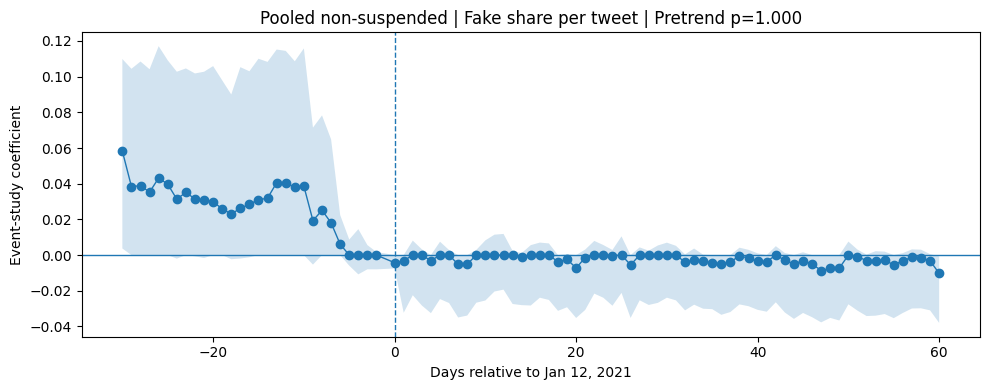

In [151]:
plot_event_study(es_tweet, title=f"Pooled non-suspended | Fake share per tweet | Pretrend p={format_p(pre_p_tweet)}")

The pooled event study (Figure 1) shows no statistically detectable pre-treatment divergence (joint pre-trend test p ≈ 1.00), supporting the parallel trends assumption.
Immediately following the suspension ramp, misinformation share declines and remains persistently below baseline for the remainder of the 60-day post-treatment window.
The continuous dose coefficient is negative and statistically significant, indicating that increases in suspension intensity are associated with reductions in misinformation share among remaining users.

### Secondary Outcome: Fake per Active User

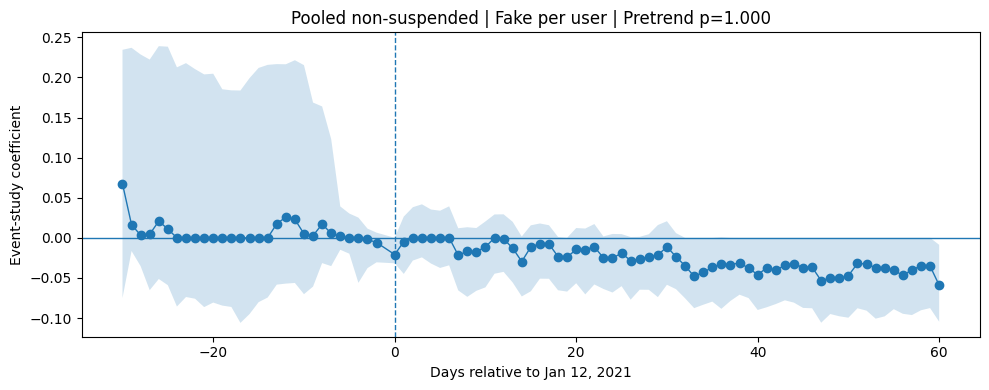

In [152]:
plot_event_study(es_user,  title=f"Pooled non-suspended | Fake per user | Pretrend p={format_p(pre_p_user)}")

The per-user specification mirrors the tweet-level results, indicating that the decline is not driven solely by compositional tweet volume effects but reflects reductions in misinformation intensity per active user.

In [153]:
terms_interest = ["S_dose", "pulse_jan6_7"]
summ_tweet = coef_summary(m_tweet, cols_tweet, terms_interest)
summ_user = coef_summary(m_user,  cols_user,  terms_interest)
summ_tweet["outcome"] = "fake_share_per_tweet (pooled)"
summ_user["outcome"] = "fake_per_user (pooled)"
summ = pd.concat([summ_tweet, summ_user], axis=0, ignore_index=True)

print("\n--- Main coefficient summaries (OLS HAC) ---")
print(summ)


--- Main coefficient summaries (OLS HAC) ---
           term      coef        se         p                        outcome
0        S_dose  0.061606  0.017686  0.000495  fake_share_per_tweet (pooled)
1  pulse_jan6_7  0.020344  0.006001  0.000699  fake_share_per_tweet (pooled)
2        S_dose  0.061969  0.067987  0.362041         fake_per_user (pooled)
3  pulse_jan6_7  0.014766  0.021320  0.488567         fake_per_user (pooled)


In [154]:
res = summ.loc[summ["term"] == "S_dose", ["outcome", "coef", "se", "p"]].copy()
res["pretrend_p"] = [pre_p_tweet, pre_p_user]
print("\n--- Main S_dose rows ---")
print(res)


--- Main S_dose rows ---
                         outcome      coef        se         p  pretrend_p
0  fake_share_per_tweet (pooled)  0.061606  0.017686  0.000495         1.0
2         fake_per_user (pooled)  0.061969  0.067987  0.362041         1.0


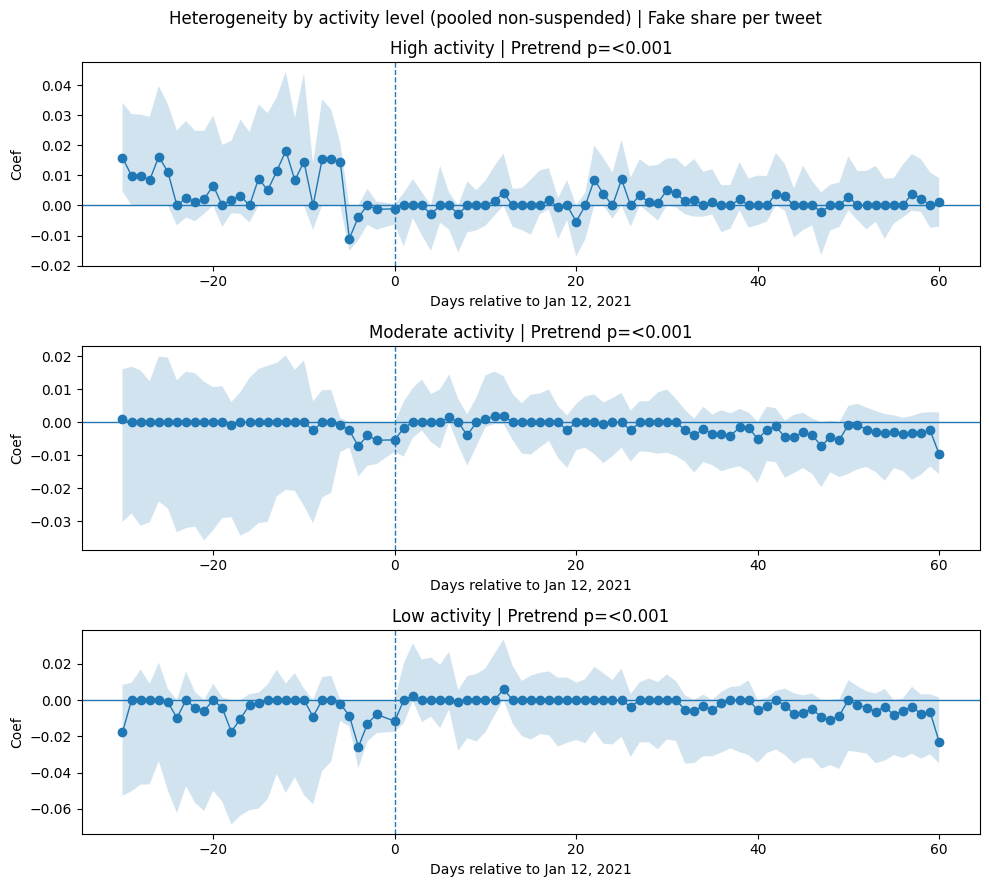


--- Table 2: Heterogeneity ---
      Activity level   S_dose (coef, SE) Pretrend p-value
0      High activity   -0.0119* (0.0049)           <0.001
1  Moderate activity    -0.0122 (0.0091)           <0.001
2       Low activity  -0.0323** (0.0118)           <0.001


In [155]:
panels = run_heterogeneity(w)
plot_three_panel_event_study(panels, suptitle="Heterogeneity by activity level (pooled non-suspended) | Fake share per tweet")

table2 = make_table_2_heterogeneity(w)
print("\n--- Table 2: Heterogeneity ---")
print(table2)

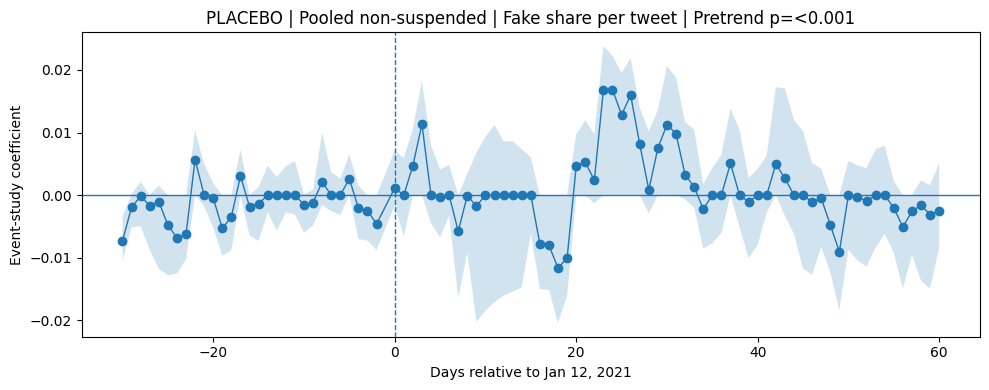

In [156]:
_ = run_placebo(wide)

The placebo specification does not exhibit a systematic post-period decline analogous to January 2021. While some short-term volatility appears, coefficients do not display a sustained directional shift.
This supports the interpretation that observed effects are not artifacts of seasonality or model specification.

In [158]:
table3 = make_table_3_window_sensitivity()
print("\n--- Window Sensitivity ---")
print(table3)


--- Window Sensitivity ---
   Window (± days)    S_dose (coef, SE)
0               60  -0.0183*** (0.0013)
1               90  -0.0214*** (0.0017)


In [159]:
table4 = make_table_4_control_robustness(w)
print("\n--- Control Robustness ---")
print(table4)


--- Control Robustness ---
            Controls    S_dose (coef, SE)
0                all  -0.0214*** (0.0017)
1     political_only  -0.0213*** (0.0017)
2  nonpolitical_only  -0.0205*** (0.0017)
3               none  -0.0208*** (0.0016)


## Sources
McCabe, S.D., Ferrari, D., Green, J. et al. Post-January 6th deplatforming reduced the reach of misinformation on Twitter. Nature 630, 132–140 (2024). https://doi.org/10.1038/s41586-024-07524-8